In [1]:
import os
import platform
import sys
import csv
import requests
import json
import operator
import time
import datetime
import nltk
import matplotlib
import matplotlib.pyplot as pyplot
# platform specific paths
if platform.system() == 'Windows':
    if not os.path.exists('..\\output'):
        os.makedirs('..\\output')   
else:
    if not os.path.exists('../output/'):
        os.makedirs('../output/')
    
print(datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S'))
print('_______________________________________________')

2018-11-06 23:19:06
_______________________________________________


In [2]:
from nltk import ngrams, FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
def writeText(text, path, mode = 'a'):          # function to work with text files
    with open (path, mode, encoding = 'utf-8') as textout:
        textout.write((text))
        
def writeJson(json, path, mode = 'w'):          # function to work with Json files
    with open(path, mode) as file:
        file.write(json.dumps(json))
        
def writeCsv(listOut, outputFile):          # function to work with csv files
    import csv
    with open (outputFile, "w", newline='', encoding = 'utf-8') as outputfile:
        writer = csv.writer(outputfile, delimiter = ",")
        for element in listOut:
            writer.writerow(element)

def getTxt(path):          # function to open text files in read mode
    return open(path, 'r').read()

def getCsv(path, delim = ',', enc = 'utf-8'):          # function to open csv files with the right encoding
    list_return = []
    with open (path, encoding = enc) as file:
        csvreader = csv.reader(file, delimiter = delim)
        for line in csvreader:
            list_return.append(line)
    return list_return

In [4]:
def getToken():          # platform specific paths for the token
    if platform.system() == 'Windows':
        return open('..\\token\\token.txt', 'r').read()
    else:
        return open('../token/token.txt', 'r').read()

In [5]:
def getJsonDocs(page = 1, itemsperpage = 200):          # function to pull the Worldbank data from the 23degree API
    jsondata ='dummy'
    list_return = []

    while jsondata:
        try:
            r = requests.get("https://app.23degrees.io/services/pub/api/v1/opendata/getWorldBankDataSetsPaginated/"+str(page)+"/"+str(itemsperpage)
                         ,timeout=None
                         ,headers={  'Content-Type': 'application/json'
                                    , 'Authorization' : 'Bearer '+ getToken()
                                   }
                        )    
            jsondata = r.json()
            for elem in jsondata:
                list_return.append(elem)
        except requests.exceptions.HTTPError as err:
            print(err)
        page += 1
    return list_return

In [6]:
def getFeaturesLabels(list_in):          # creating lists with features and labels
    list_return = []
    for elem in list_in:
        list_inner = []
        list_inner.append(elem[1])
        list_inner.append(elem[2])
        list_inner.append(elem[3])
        list_return.append(list_inner)
    return list_return

In [7]:
list_js_docs = getJsonDocs(1,200)

In [8]:
list_clean_tags_in = getCsv('..\\input\\tags_clean.csv', enc='windows-1252')[1:]
list_clean_tags_in[0]

['World Bank', '3553', 'FALSE']

In [9]:
# list_js_docs[5]

In [10]:
list_list_js_tags = [] #Format: jsondoc(str)|name(str)|description(str)|tags(list)
list_js_tags_inner = []
list_js_notags = []
list_unique_tags = []
list_tags = []
dict_tags = {}
for i, jsondoc in enumerate(list_js_docs):          # filtering tags and creating list with unique tags
    jstmp = json.dumps(jsondoc, sort_keys=True,indent=4, separators=(',', ': '))
    if 'tags' in jstmp:
        list_js_tags_inner = []
        list_js_tags_inner.append(jstmp)
        tmp_list_tags = []
        for tag in jsondoc['typeSpecific']['context']['tags']:
            tmp_list_tags.append(tag)
            list_tags.append(tag)
            if tag not in list_unique_tags:
                list_unique_tags.append(tag)
                dict_tags[tag] = 1
            else:
                dict_tags[tag] += 1
        list_js_tags_inner.append(jsondoc['name'])
        list_js_tags_inner.append(jsondoc['description'])
        list_js_tags_inner.append(tmp_list_tags)
        list_list_js_tags.append(list_js_tags_inner)
                
    else:
        list_js_notags.append(jstmp)

In [11]:
list_tags_sorted = list(sorted(dict_tags.items(), key=lambda x: x[1], reverse = True))
ll_name_desc_tags = getFeaturesLabels(list_list_js_tags)       # List of lists with name description and tags

In [12]:
print('Json-Files: ', len(list_js_docs))
print('Json-Files with tags: ', len(list_list_js_tags))
print('Json-Files without tags: ', len(list_js_notags))
print('Unique tags: ', len(list_tags_sorted))

Json-Files:  4580
Json-Files with tags:  3573
Json-Files without tags:  1007
Unique tags:  2848


In [13]:
list_tags[0:20]

['Social Issues',
 'Politics',
 'Business_Finance',
 'Environment',
 'Economy',
 'National accounts',
 'Health systems by country',
 'Military budget',
 'World Bank Domestic',
 'World Bank',
 'Social Issues',
 'Environment',
 'Business_Finance',
 'Politics',
 'Economy',
 'National accounts',
 'Health systems by country',
 'Military budget',
 'World Bank Domestic',
 'World Bank']

In [14]:
fdist_total_tags = FreqDist(list_tags)      # calculating the frequency of the labels and create a csv with most common tags
fdist_total_tags.most_common(100)
if platform.system() == 'Windows':
    writeCsv(fdist_total_tags.most_common(500), '..\\output\\tags.csv')
else:
    writeCsv(fdist_total_tags.most_common(500), '../output/tags.csv')

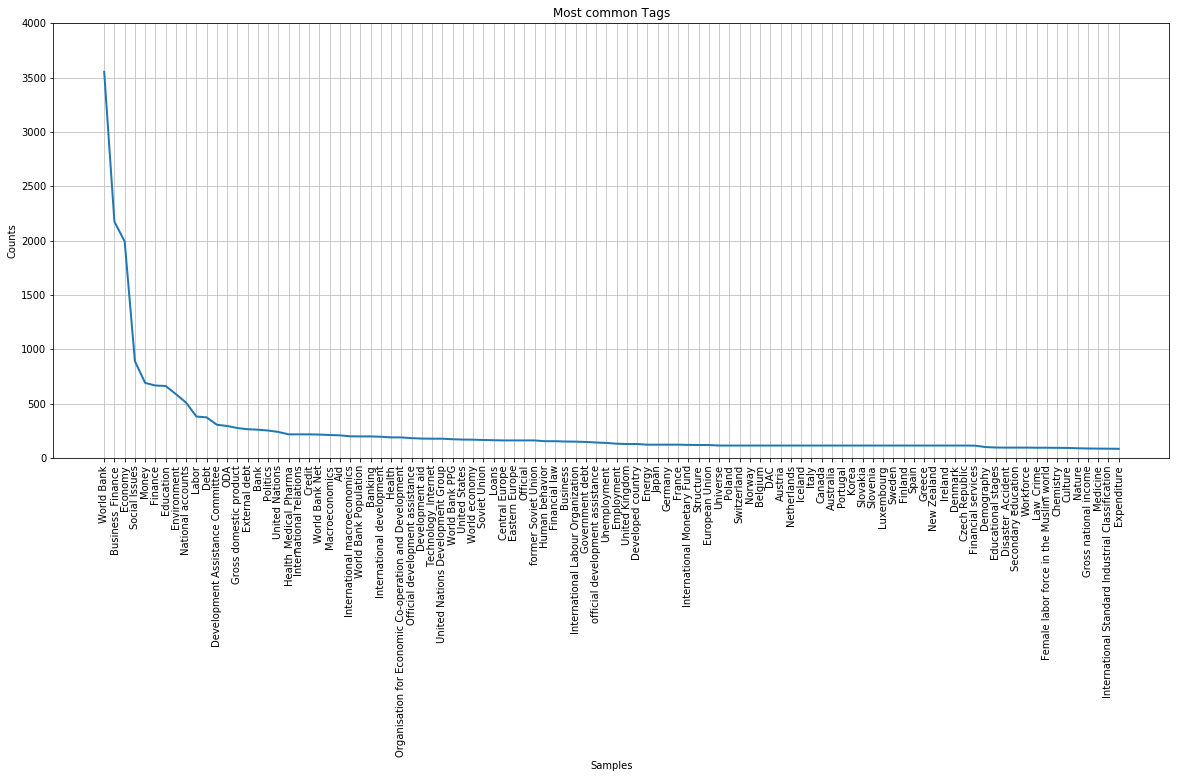

In [15]:
pyplot.figure(figsize=(20, 8))
pyplot.ylim(0, 4000)
fdist_total_tags.plot(100, title = 'Most common Tags')

### Which tags should be ignored?

Only tags appearing less than 1000 times?

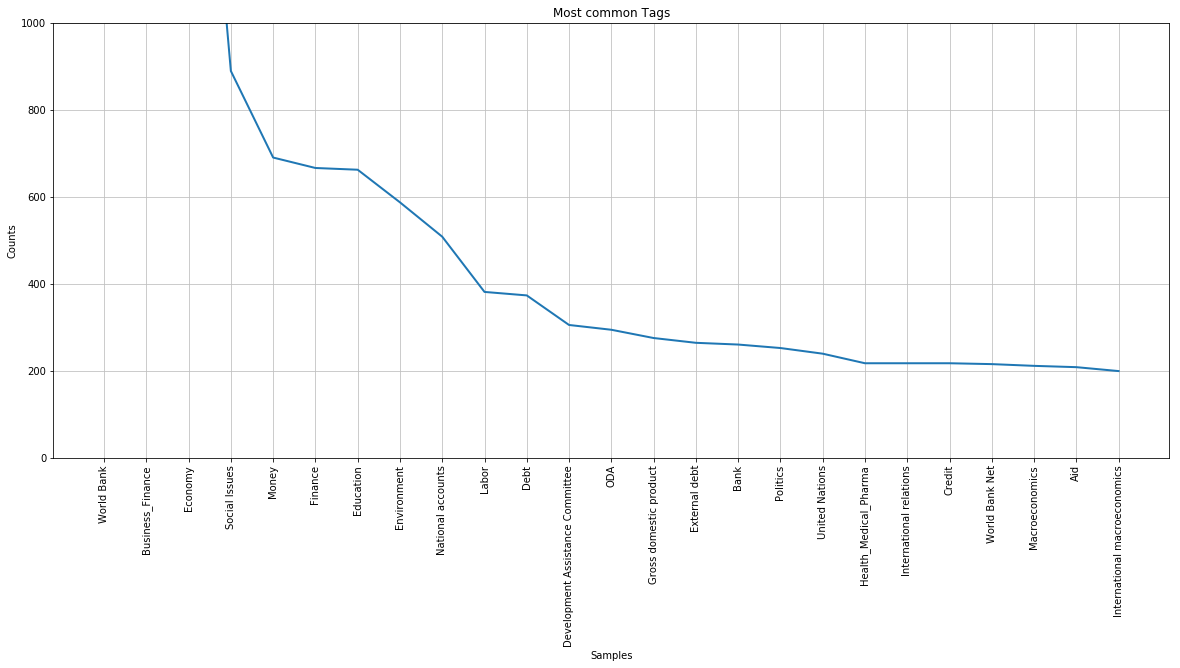

In [16]:
pyplot.figure(figsize=(20, 8))
pyplot.ylim(0, 1000)
fdist_total_tags.plot(25, title = 'Most common Tags')

* excluding first 3 tags
* assumption: take the first 200 most common tags

### Cleaning Label List

In [17]:
# cleaning list_tags

for i, tag in enumerate(list_tags):
    if tag == 'World Bank':
        list_tags[i] = 'Worldbank'
    else:
        for tag_in in list_clean_tags_in:
            if (tag_in[0] == tag) & (tag_in[2] == 'TRUE'):
                del list_tags[i]

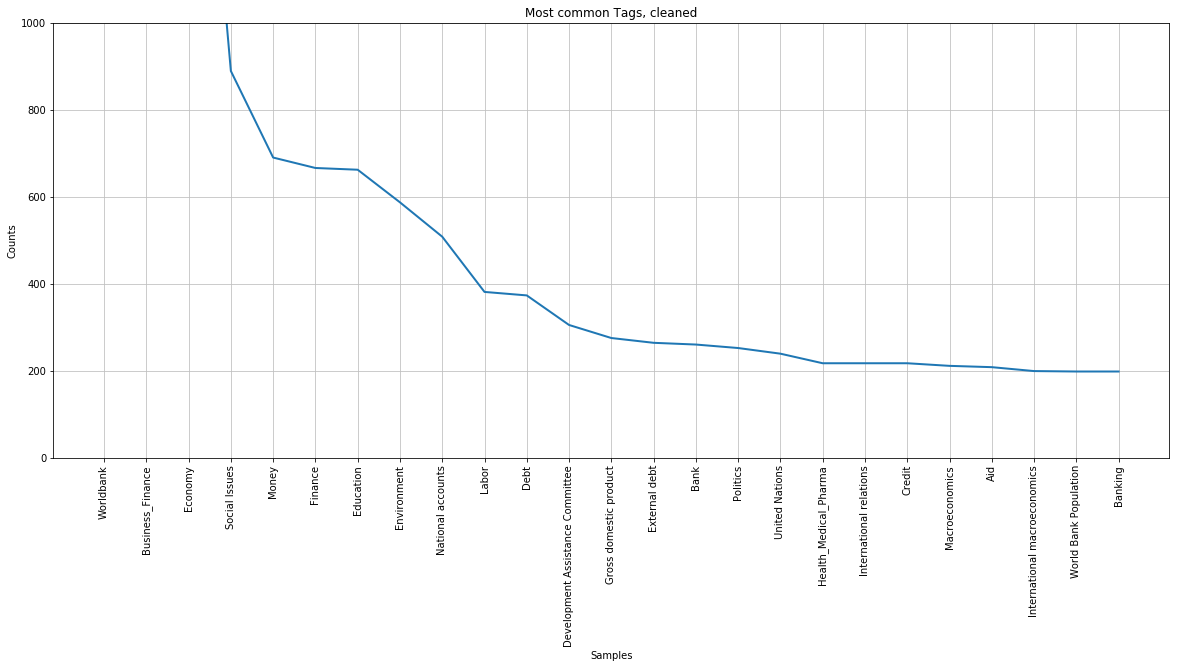

In [18]:
fdist_total_tags = FreqDist(list_tags)
pyplot.figure(figsize=(20, 8))
pyplot.ylim(0, 1000)
fdist_total_tags.plot(25, title = 'Most common Tags, cleaned')

### Choose Number of Label

In [19]:
def chooseTags(list_tags,first,topx):
    list_chosen = []
    list_notchosen = []
    for i, elem in enumerate(list_tags):
        if (i > first) & (i < (topx+first+1)):
            list_chosen.append(elem[0].lower())   
        else:
            list_notchosen.append(elem[0].lower()) 
        
    return list_chosen, list_notchosen

In [20]:
list_chosen_tags = chooseTags(list_tags_sorted,2,300)   # top 300 tags where chosen to work with in the further process (wothout first 2, since they are too general and don't add any value)

### Removing not used tags and fillerwords from name and describtion:

In [21]:
list_fillerwords = getTxt('../input/fillerwords.txt').split(',') + stopwords.words('english')

In [22]:
# string cleaning 1
porterstemmer = PorterStemmer()
lemmatizer = nltk.WordNetLemmatizer()
for i, elem in enumerate(ll_name_desc_tags):
    #preparing name (title) filtering out special characters, change into lower characters and lemmatizing tags
    ll_name_desc_tags[i][0] = nltk.word_tokenize(''.join([x for x in elem[0] if not x.isdigit()]).replace('-',' ').replace('.','').replace(',','').replace('%','').replace('(','').replace(')',''))
    for word in list_fillerwords:
        while (word in ll_name_desc_tags[i][0]):
            ll_name_desc_tags[i][0].remove(word)
    for j, word in enumerate(ll_name_desc_tags[i][0]):
        ll_name_desc_tags[i][0][j] = ll_name_desc_tags[i][0][j].lower()
        lemmatizer.lemmatize(porterstemmer.stem(ll_name_desc_tags[i][0][j]))
    # preparing description filtering out special characters, change into lower characters and lemmatizing tags
    ll_name_desc_tags[i][1] = nltk.word_tokenize(''.join([x for x in elem[1] if not x.isdigit()]).replace('-',' ').replace('.','').replace(',','').replace('%','').replace('(','').replace(')',''))
    for word in list_fillerwords:
        while (word in ll_name_desc_tags[i][1]):
            ll_name_desc_tags[i][1].remove(word)
    for j, word in enumerate(ll_name_desc_tags[i][1]):
        ll_name_desc_tags[i][1][j] = ll_name_desc_tags[i][1][j].lower()
        lemmatizer.lemmatize(porterstemmer.stem(ll_name_desc_tags[i][1][j]))
        
    # changing labels into lower case
    for j, word in enumerate(ll_name_desc_tags[i][2]):
        ll_name_desc_tags[i][2][j] = ll_name_desc_tags[i][2][j].lower()   
        
    # removing not chosen labels
    for tag in list_chosen_tags[1]:
        while (tag in ll_name_desc_tags[i][2]):
            ll_name_desc_tags[i][2].remove(tag)
        
#     # split labels        
#     list_1_tmp_tags = []
#     for j, word in enumerate(ll_name_desc_tags[i][2]):
#         if '-' in word:
#             list_2_tmp_tags = word.split('-')
#         elif '_' in word:
#             list_2_tmp_tags = word.split('_')
#         else:
#             list_2_tmp_tags = word.split(' ')
#         for sword in list_2_tmp_tags:
#             list_1_tmp_tags.append(sword.lower())
            
#     # finalise labels
#     ll_name_desc_tags[i][2] = []
#     for word in list_1_tmp_tags:
#         ll_name_desc_tags[i][2].append(word)

### Calculate cover ratio

In [23]:
cnt = 0
cnt2 = 0
cnt3 = 0
print('Anzahl der Labels: ', len(list_chosen_tags[0]))
for i, elem in enumerate(ll_name_desc_tags):    # calculate the amount of datasets covered by 1, 2 or 3 labels, when a total of 300 labels is used
    if not ll_name_desc_tags[i][2]:
        cnt += 1
    if len(ll_name_desc_tags[i][2]) < 3:
        cnt2 += 1
    if len(ll_name_desc_tags[i][2]) < 4:
        cnt3 += 1
        
        
print('Anzahl an ungedeckten Datensätzen: ', cnt)
print('Anteil der gedeckten Datensätze: ', 1-(cnt/len(ll_name_desc_tags)))
print('Anzahl der Datensätze mit weniger als 2 Label: ', cnt2)
print('Anteil der Datensätze mit mehr als 2 Label: ', 1-(cnt2/len(ll_name_desc_tags)))
print('Anzahl der Datensätze mit weniger als 3 Label: ', cnt3)
print('Anteil der Datensätze mit mehr als 3 Label: ', 1-(cnt3/len(ll_name_desc_tags)))

Anzahl der Labels:  300
Anzahl an ungedeckten Datensätzen:  35
Anteil der gedeckten Datensätze:  0.9902043101035545
Anzahl der Datensätze mit weniger als 2 Label:  470
Anteil der Datensätze mit mehr als 2 Label:  0.8684578785334452
Anzahl der Datensätze mit weniger als 3 Label:  845
Anteil der Datensätze mit mehr als 3 Label:  0.7635040582143857


In [24]:
if platform.system() == 'Windows':   # save list of lists with chosen names, descriptions and tags in a CSV (prep_out.csv)
    writeCsv(ll_name_desc_tags, '..\\output\\prep_out.csv')
else:
    writeCsv(ll_name_desc_tags, '../output/prep_out.csv')

In [25]:
print(datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S'))
print('\n\n_______________________________________________')

2018-11-06 23:19:39


_______________________________________________
